In [470]:
import json
#from fastdtw import fastdtw
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
import itertools
import sklearn
from matplotlib import rc

rc('text', usetex=True)

sns.set(font='serif', style='white')

In [379]:
with open('tmp/cuysq_6000_preserve3b_shortlearnedseen.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetracelearned = json.load(f)['data'][1::]
print(len(statetracelearned[0]),len(statetracelearned))

480 15


In [380]:
sensornames = ['S'+str(idx) for idx in range(16)]
def create_trace(data):
    t = {}
    for s in sensornames:
        t[s] = np.asarray([i[s] for i in data])#[select[0]:select[1]]])
    return t
alltraces = create_trace([i for j in statetracelearned for i in j])

In [331]:
def extract_feature(t):
    is_active = lambda i:i[0]==0 and i[1]>0
    is_idle = lambda i:i[0]==1 and i[1]>0
    is_sleep = lambda i:i[0]==2 and i[1]>0
    is_dead = lambda i:i[1]==0
    counter = lambda data, f: len([i for i in data if f(i)])
    return [counter(t, f) for f in [is_active,is_idle,is_sleep,is_dead]]
def extract_timesensitive_feature(t):
    sorted_by_time = sorted(t, key=lambda i:i[3])
    grouped_by_time = itertools.groupby(sorted_by_time, key=lambda i:i[3])
    features_by_time = {k:extract_feature(list(v)) for k,v in grouped_by_time}
    keys = sorted(list(set([k for k in features_by_time])))
    return np.asarray(list(itertools.chain(*[features_by_time[k] for k in keys])))
def extract_daynight_feature(t):
    sorted_by_time = sorted(t, key=lambda i:int(i[3]) in [1,2,3])
    grouped_by_time = itertools.groupby(sorted_by_time, key=lambda i:int(i[3]) in [1,2,3])
    features_by_time = {k:extract_feature(list(v)) for k,v in grouped_by_time}
    keys = sorted(list(set([k for k in features_by_time])))
    return np.asarray(list(itertools.chain(*[features_by_time[k] for k in keys])))    
#extract_timesensitive_feature(traces['S1'])


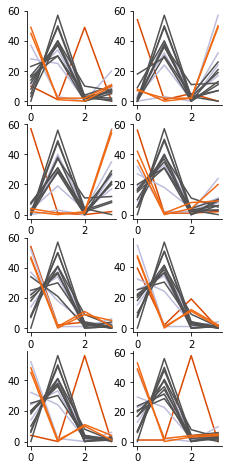

In [413]:
#for run in statetracelearned:
with open('tmp/cuysq_6000_preserve3b_shortlearnedseen.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetracelearned = json.load(f)#['data'][1::]
run=3
startday = 38
periods = 8#in three hours 8 periods make a full day
duration =4#days
select = [startday*periods,(startday+duration)*periods]
data = statetracelearned['data'][run]#[select[0]:select[1]]
#print([i['S15'][0] for i in data[select[0]:select[1]]])
#data = statetracelearned[run][select[0]:select[1]]
thisrun = create_trace(data)
groups = {'worker':['S15','S0','S6','S12'],
              'idler':['S3','S4','S5','S13','S14','S10','S11','S7','S9'],#+['S11','S14','S13'],
              'saver':['S1','S8'],
              'ubersaver':['S2']}#,'S2']}
colorkey = {'worker':["#bcbddc"]
                ,'idler':["#525252"]
                ,'saver':["#f16913"]
                ,'ubersaver':["#d94801"]}
fig, axarr = plt.subplots(4,2)
fig.set_size_inches(3.5,8)
for idx, ax in enumerate(itertools.chain(*axarr)):
    for g, sensors in groups.items():
        for e,s in enumerate(sensors):
            feature = extract_timesensitive_feature(thisrun[s])
            #if g=='worker':
            zindex = 100 if g=='saver' else 0
            if g in ['idler','worker','saver','ubersaver']:
                ax.plot(feature[idx*4:idx*4+4], label=s, color=colorkey[g][0], zorder=zindex)
sns.despine()

In [269]:
def feature_to_3d(feature, number_aggregated = 1):
    scale = 300*number_aggregated
    xs = [feature[2+(4*t)]/scale for t in range(8)]
    ys = [(feature[1+(4*t)])/scale for t in range(8)]#[(feature[1+(4*t)]-feature[0]+(4*t))/scale for t in range(8)]
    zs = [feature[3+(4*t)]/scale for t in range(8)]
    return xs,ys,zs
def feature_2d_all(feature,number_aggregated = 1):
    scale = 300*number_aggregated
    actives = [feature[0+(4*t)]/scale for t in range(8)]
    idles = [feature[1+(4*t)]/scale for t in range(8)]
    standbys= [feature[2+(4*t)]/scale for t in range(8)]
    offs = [feature[3+(4*t)]/scale for t in range(8)]
    return [np.mean(feature) for feature in [actives,idles,standbys,offs]]

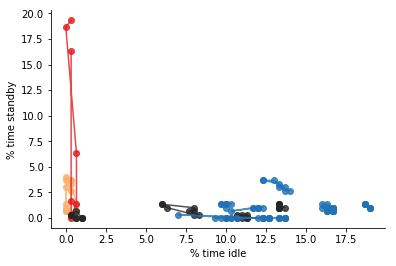

In [416]:
fig = plt.figure()
ax =fig.add_subplot(111)
def plot2d(data,ax,aggregated = 1):
    groups = {'worker':['S15','S0','S6','S12'],
              'idler':['S3','S4','S5','S13','S14','S10','S11','S7','S9'],#+['S11','S14','S13'],
              'saver':['S1','S8'],
              'ubersaver':['S2']}#,'S2']}
    colorkey = {'worker':["#252525","#000000"]
                ,'idler':["#2171b5"]
                ,'saver':["#fdae6b","#fd8d3c","#f16913","#d94801","#a63603","#7f2704"]
                ,'ubersaver':["#e31a1c"]}
    for g, sensors in groups.items():
        for idx,s in enumerate(sensors):
            feature = extract_timesensitive_feature(data[s])
            linerepx, linerepy,linerepz = feature_to_3d(feature,aggregated)
            #ax.scatter(100*np.mean(linerepy),100*np.mean(linerepx),color=colorkey[g][0],alpha=0.7)#
            #if g=='saver':
            ax.plot([100*i for i in linerepy],[100*i for i in linerepx],color=colorkey[g][0],alpha=0.8, marker='o')
    return ax
#for run in statetracelearned:
plotdata = create_trace(data)
number_aggregated = 1
ax = plot2d(plotdata,ax, 1)
#ax = plot2d(alltraces,ax,15)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylim([-9,50])
#ax.set_xlim([-1,1])
ax.set_ylabel('% time standby')
ax.set_xlabel('% time idle')
sns.despine()

In [235]:
groups = {'worker':['S4','S5','S6','S0','S3'],
              'idler':['S12','S10','S9','S15']+['S13','S11','S14','S7'],
              'saver':['S8','S1','S2'],
              'special':[]}
colorkey = {'worker':["#252525","#000000"]
                ,'idler':["#bcbddc","#9e9ac8","#807dba","#6a51a3","#54278f","#3f007d"]
                ,'saver':["#fdae6b","#fd8d3c","#f16913","#d94801","#a63603","#7f2704"]
                ,'special':['#d9d9d9']}
def pcamatrix(raw):
    matrix = np.zeros((5*16,32))
    allsensors = ['S'+str(idx) for idx in range(16)]
    for i in range(5):
        for e,s in enumerate(allsensors):
            data= create_trace(raw[i])
            feature = extract_timesensitive_feature(data[s])
            matrix[16*i+e,:] = np.array([i/(300) for i in feature])
    return matrix
def pca_avg(raw):
    matrix = np.zeros((16,32))
    allsensors = ['S'+str(idx) for idx in range(16)]
    data = create_trace([i for j in statetracelearned for i in j])
    for e,s in enumerate(allsensors):
        feature = extract_timesensitive_feature(data[s])
        matrix[e,:] = np.array([i/(300*5) for i in feature])
    return matrix  

In [236]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
m = pcamatrix(statetracelearned)
model = pca.fit(m)
pca_big = model.transform(m)

In [237]:
average_m = pca_avg(statetracelearned)
avg_model = pca.fit(m)
pca_mat = avg_model.transform(average_m)

In [ ]:
sns.heatmap()

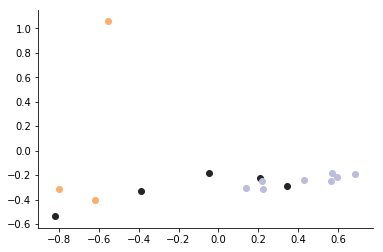

In [240]:
fig,ax = plt.subplots(1)
for idx,row in enumerate(pca_mat):
    sensor = idx%16
    sensorname = 'S'+str(sensor)
    nodeclass = [k for k,v in groups.items() if sensorname in v]
    ax.scatter(row[0], row[1], label=sensorname, color = colorkey[nodeclass[0]][0])
sns.despine()

In [368]:
data = np.zeros((16,16))
traces = create_trace(statetracelearned[3])
for x,y in itertools.product(sensornames, repeat=2):#, repeat=2):
    idx1 = sensornames.index(x)
    idx2 = sensornames.index(y)
    d = distance.euclidean(extract_timesensitive_feature(traces[x]), extract_timesensitive_feature(traces[y]))
    data[idx1,idx2] = d
#distance, path = fastdtw(traces['S1'], traces['S1'])#, dist=euclidean)

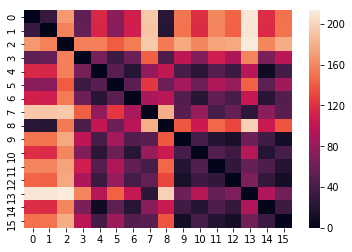

In [369]:
sns.heatmap(data)

[[38.  3.  0. 19.  0.  3.  0. 57.  1.  2.  0. 57. 33.  3.  0. 24. 52.  1.
   1.  6. 54.  1.  1.  4. 52.  2.  0.  6. 48.  2.  0. 10.]
 [43.  2.  2. 13.  7.  2.  2. 49.  5.  1.  1. 53. 47.  2.  5.  6. 47.  2.
   8.  3. 48.  2.  8.  2. 46.  2.  8.  4. 47.  2.  4.  7.]
 [10.  1. 49.  0. 58.  1.  1.  0. 58.  1.  0.  1. 56.  1.  1.  2. 50.  1.
   9.  0. 37.  1. 22.  0.  3.  0. 57.  0.  0.  0. 60.  0.]
 [36.  9.  0. 15.  1.  9.  0. 50.  1.  8.  1. 50. 35.  8.  0. 17. 48.  8.
   0.  4. 50.  8.  0.  2. 48.  9.  0.  3. 43.  8.  1.  8.]
 [17. 40.  0.  3.  2. 40.  0. 18.  1. 39.  0. 20. 13. 42.  0.  5. 17. 42.
   0.  1. 18. 41.  0.  1. 17. 41.  0.  2. 17. 40.  0.  3.]
 [20. 29.  4.  7.  0. 29.  4. 27.  0. 27.  4. 29. 17. 28.  4. 11. 25. 28.
   4.  3. 26. 28.  4.  2. 25. 27.  5.  3. 22. 28.  5.  5.]
 [25. 14.  3. 18.  3. 11.  5. 41.  6.  8.  5. 41. 26.  8.  5. 21. 40.  9.
   5.  6. 39. 14.  3.  4. 37. 14.  4.  5. 29. 16.  2. 13.]
 [14. 41.  0.  5.  1. 40.  0. 19.  2. 38.  0. 20. 14. 41.  0.  5. 16.

[[37.  1.  0. 22.  0.  1.  0. 59.  0.  1.  0. 59. 33.  1.  0. 26. 54.  0.
   0.  6. 56.  0.  0.  4. 54.  0.  0.  6. 50.  0.  0. 10.]
 [42.  2.  4. 12. 13.  1.  5. 41. 13.  1.  3. 43. 34.  2.  8. 16. 40.  2.
  14.  4. 42.  2. 14.  2. 39.  4. 12.  5. 42.  1. 10.  7.]
 [16.  3. 41.  0. 50.  1.  9.  0. 53.  1.  3.  3. 55.  1.  2.  2. 44.  2.
  11.  3. 29.  1. 29.  1.  1.  0. 59.  0.  1.  0. 59.  0.]
 [ 0.  1. 59.  0.  0.  1. 59.  0.  0.  1. 59.  0.  0.  0. 60.  0.  0.  0.
  60.  0.  0.  0. 60.  0.  0.  0. 60.  0.  0.  0. 60.  0.]
 [ 8. 43.  2.  7.  1. 43.  2. 14.  0. 40.  3. 17.  8. 43.  3.  6. 12. 44.
   2.  2. 13. 44.  2.  1. 12. 44.  2.  2. 11. 43.  2.  4.]
 [11. 39.  4.  6.  0. 39.  4. 17.  1. 38.  4. 17. 12. 39.  4.  5. 16. 38.
   4.  2. 17. 38.  4.  1. 18. 37.  4.  1. 14. 38.  4.  4.]
 [20. 20.  5. 15.  3. 16.  6. 35.  6. 11.  6. 37. 28. 11. 10. 11. 40.  9.
  11.  0. 35. 17.  7.  1. 32. 17.  7.  4. 28. 18.  4. 10.]
 [20. 30.  1.  9.  0. 30.  1. 29.  0. 30.  1. 29. 18. 28.  2. 12. 24.

[[31.  4.  1. 24.  0.  4.  1. 55.  0.  4.  1. 55. 29.  6.  1. 24. 49.  5.
   0.  6. 51.  4.  1.  4. 51.  2.  1.  6. 42.  3.  0. 15.]
 [44.  1.  2. 13.  7.  1.  1. 51.  7.  1.  0. 52. 42.  1.  8.  9. 47.  1.
   8.  4. 49.  2.  7.  2. 47.  2.  7.  4. 47.  1.  4.  8.]
 [10.  1. 49.  0. 52.  1.  7.  0. 57.  1.  1.  1. 57.  1.  1.  1. 44.  1.
  14.  1. 34.  1. 25.  0.  5.  0. 55.  0.  0.  0. 60.  0.]
 [31.  1. 17. 11.  1.  1. 17. 41.  0.  0. 18. 42. 30.  0. 17. 13. 39.  0.
  17.  4. 40.  0. 18.  2. 39.  0. 18.  3. 36.  0. 17.  7.]
 [40.  3.  0. 17.  3.  2.  0. 55.  1.  2.  0. 57. 38.  3.  0. 19. 53.  3.
   0.  4. 55.  3.  0.  2. 53.  3.  0.  4. 49.  2.  0.  9.]
 [13. 38.  0.  9.  0. 38.  0. 22.  0. 36.  0. 24. 12. 38.  0. 10. 21. 38.
   0.  1. 21. 38.  0.  1. 20. 38.  0.  2. 18. 38.  0.  4.]
 [32. 12.  4. 12.  1. 11.  4. 44.  3. 11.  2. 44. 32. 12.  2. 14. 43. 12.
   3.  2. 45. 10.  4.  1. 42. 11.  4.  3. 37. 11.  4.  8.]
 [ 7. 52.  0.  1.  1. 51.  0.  8.  1. 48.  1. 10.  7. 51.  1.  1.  9.

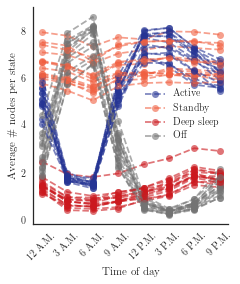

In [692]:
arun = create_trace(statetracelearned['data'][3])
def count_by_time(alldata):
    timecounts = np.zeros((16,32))
    for idx in range(16):
        feature = extract_timesensitive_feature(alldata['S'+str(idx)])
        timecounts[idx,:] = feature
    print(timecounts)
    aggregated = np.sum(timecounts, axis=0)
    return aggregated
        
def makefig(traces):
    fig,ax = plt.subplots(1)
    fig.set_size_inches(3.5,4)
    labels = {0:'Active',1:'Standby',2:'Deep sleep',3:'Off'}
    cmap = {0:'#253494',
             1:'#f05f40',
             2:'#cb181d',
                 3:'#737373'}
    for r in range(2,16):
        arun = create_trace(traces['data'][r])
        counts = count_by_time(arun)
        for i in range(4):
            ax.plot(16*counts[i::4]/960, label=labels[i] if r==15 else '',
                linestyle='--', marker='o', color=cmap[i], alpha=0.6)
    ax.legend()
    ax.set_ylabel('Average \# nodes per state')
    ax.set_xlabel('Time of day')
    ax.set_xticks([i for i in range(8)])
    xlabels = ['12 A.M.','3 A.M.','6 A.M.','9 A.M.','12 P.M.','3 P.M.','6 P.M.','9 P.M.','12 A.M.']
    ax.set_xticklabels(xlabels, rotation=45)
#print(feature))
#alldata(statetracelearned[run])
#fig,ax = plt.subplots(1)
    sns.despine()
    return fig,ax

fig,ax = makefig(statetracelearned)
#fig.savefig('temporal.png', dpi=600)

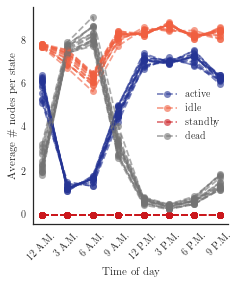

In [501]:
with open('tmp/hfcte_naivelong.json') as f:
    naivetrace = json.load(f)
#print(naivetrace['data'][2])
fig,ax = makefig(naivetrace)

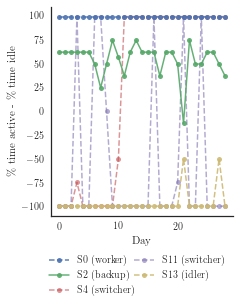

In [690]:
#next plot moving average of nodes %active - % idle
fig,ax = plt.subplots(1)
fig.set_size_inches(3.5,4.5)
arun = create_trace(statetracelearned['data'][4][240::])
saver_group = [2]
always_on = [0]
interesting = [4,11]
idler = [13]
def idle_per_slice(sliced):
    idle = [state[0] == 1 for state in sliced if state[1]>0]
    return 100*sum(idle)/len(idle)
def active_per_slice(sliced):
    active = [state[0] == 0 for state in sliced if state[1]>0]
    return 100*sum(active)/len(active)
for s in range(16):
    feature = [active_per_slice(arun['S'+str(s)][idx:idx+8,:])-idle_per_slice(arun['S'+str(s)][idx:idx+8,:])
               for idx in [i*8 for i in range(29)]]
    if s in interesting:
        ax.plot(feature, alpha=0.6, linestyle='--', marker='o',label='S'+str(s)+' (switcher)', markersize=5, linewidth=1.5)
    if s in saver_group:
        ax.plot(feature, alpha=0.9,linestyle='-',marker='o', label='S'+str(s)+' (backup)', markersize=5,zorder=1000, linewidth=1.5)
    if s in idler:
        ax.plot(feature, alpha=0.9, linestyle='--', marker='o',label='S'+str(s) +' (idler)', markersize=5,zorder=100, linewidth=1.5)
    if s in always_on:
        ax.plot(feature, alpha=0.9, linestyle='--', marker='o',label='S'+str(s) +' (worker)', markersize=5,zorder=100, linewidth=1.5)
    
    #else:
    #    ax.plot(feature, alpha=0.1)
    sns.despine()
ax.legend(bbox_to_anchor=(1,-0.15),ncol=2, columnspacing=0)
ax.set_xlabel('Day')
ax.set_ylabel('\% time active - \% time idle')
fig.tight_layout()
fig.savefig('individualtemporal.png', dpi=600)


In [753]:
def counter(state):
    is_active = lambda i:i[0]==0 and i[1]>0
    is_idle = lambda i:i[0]==1 and i[1]>0
    is_sleep = lambda i:i[0]==2 and i[1]>0
    is_dead = lambda i:i[1]==0
    counter = lambda data, f: len([i for i in data if f(i)])
    return [counter(step, f) for f in [is_active,is_idle,is_sleep,is_dead]]
def step_counter(step):
    is_active = lambda i:i[0]==0 and i[1]>0
    is_idle = lambda i:i[0]==1 and i[1]>0
    is_sleep = lambda i:i[0]==2 and i[1]>0
    is_dead = lambda i:i[1]==0
    activecounts = len([v for k,v in step.items() if is_active(v)])
    idlecounts = len([v for k,v in step.items() if is_idle(v)])
    stopcounts = len([v for k,v in step.items() if is_sleep(v)])
    deadcounts = len([v for k,v in step.items() if is_dead(v)])
    res = {'active':activecounts,'idle':idlecounts,'stop':stopcounts,'dead':deadcounts}
    #for k in res:
    #    yield {'category':k,'Number of sensors':res[k]}
    return res
def count_times(t, data):
    res = [step_counter(i) for i in data[t::8]]
    #for i in res:
    #    i['t'] = t
    return res

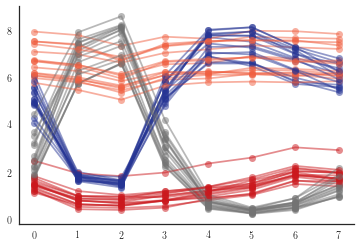

In [782]:
fig,ax = plt.subplots(1)  
def modeplotter(data,ax):
    res = [count_times(t, data) for t in range(8)]
    modefinder = lambda lst: max(set(lst), key=lst.count)
    modefinder = np.mean
    cmap = {0:'#253494',
             1:'#f05f40',
             2:'#cb181d',
                 3:'#737373'}
    ax.plot([modefinder([i['active'] for i in res[j]]) for j in range(8)], color=cmap[0]
           ,alpha=0.5,marker='o')
    ax.plot([modefinder([i['idle'] for i in res[j]]) for j in range(8)],color=cmap[1]
           ,alpha=0.5,marker='o')
    ax.plot([modefinder([i['dead'] for i in res[j]]) for j in range(8)],color=cmap[3]
            ,alpha=0.5,marker='o')
    ax.plot([modefinder([i['stop'] for i in res[j]]) for j in range(8)],color=cmap[2]
            ,alpha=0.5,marker='o')
    return ax
for run in statetracelearned['data'][1::]:
    dataset = run#[240::]
    ax = modeplotter(dataset, ax)
sns.despine()